In [30]:
import hashlib
import os
import pickle
from urllib.request import urlretrieve
import urllib.error 
import numpy as np
import tensorflow as tf
import math
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.utils import resample
from tqdm import tqdm
from zipfile import ZipFile
from tensorflow.python.ops.variables import Variable
%matplotlib inline


print('All modules imported.')

train_hash_key = 'c8673b3f28f489e9cdf3a3d74e2ac8fa'
test_hash_key = '5d3c7e653e63471c88df796156a9dfa9'
train_url = 'https://s3.amazonaws.com/udacity-sdc/notMNIST_train.zip'
test_url = 'https://s3.amazonaws.com/udacity-sdc/notMNIST_test.zip' 
train_repository = 'notMNIST_train.zip'
test_repository = 'notMNIST_test.zip'
pickle_file = 'notMNIST.pickle'

All modules imported.


In [31]:
class DataProvider(object):
    def __init__(self,source, repository, train_hash_key, test_hash_key, pkfile):
        
            print('Status of Initialization Step #0')
            if source is None:
                print('None source parameter is not allowed. Please, provide a source parameter.')
                return None
            if len(source)==0:
                print("Empty source parameter is not allowed. Please, provide a valid source parameter.")
                return None
            if repository is None:
                print('None repository parameter is not allowed. Please, provide a repository parameter.')
                return None
            if len(repository)==0:
                print("Empty repository parameter is not allowed. Please, provide a valid repository parameter.")
                return None
            if train_hash_key is None:
                print('None train_hash_key parameter is not allowed. Please, provide a train_hash_key parameter.')
                return None
            if len(train_hash_key)==0:
                print("Empty train_hash_key parameter is not allowed. Please, provide a valid train_hash_key parameter.")
                return None
            if test_hash_key is None:
                print('None test_hash_key parameter is not allowed. Please, provide a test_hash_key parameter.')
                return None
            if len(test_hash_key)==0:
                print("Empty test_hash_key parameter is not allowed. Please, provide a valid test_hash_key parameter.")
                return None
            if pkfile is None:
                print('None pkfile parameter is not allowed. Please, provide a pkfile parameter.')
                return None
            if len(pkfile)==0:
                print("Empty pkfile parameter is not allowed. Please, provide a valid pkfile parameter.")
                return None
            #try :
            self.source = source
            self.repository=repository
            self.train_hash_key = train_hash_key
            self.test_hash_key = test_hash_key
            self.pkfile = pkfile
            self.downloaded = 0
            self.normalized = False
            self.encoded = False
            self.uncompressed = 0
            self.hash_checked = False
            self.dataset_splited = False
            self.datacached = False
            self.dataloaded = False
            #except "Attribute Error" :
            if os.path.isfile(pkfile):
                print('Status of the Initialization step : The dataset is already serailized. If you want to \
                        to serialize it again, please remove the picke file :' + pkfile)
                self.datacached = True
            else :
                print('Status of the Initialization step : The dataset is intialized \
                    and is ready for the serialization process')
    
    def download(self):
        print('Download Step #1')
        for src, rep in tqdm(zip(self.source, self.repository)):
            try :
                if not os.path.isfile(rep):
                    print('Start download files from '+src+'...')
                    urlretrieve(src,rep)
                    print('Download finished.')
                    self.downloaded += 1
                else :
                    print('Repository path '+rep+ ' is file! We can not save\
                            files because no directory path is provided.')
            except urllib.error.URLError:
                    print('file not found corresponding to ' + src +'. moving on...')
                    raise
                    
        if self.downloaded != 0 :
            print('Status of download Step : ' +str(self.downloaded) + ' files are downloaded over '+\
                      str(len(self.source)))
    
    def checkHash(self, trainhashkey, testhashkey):
        # Make sure the files aren't corrupted
        print('Hash Check Step #2')
        try :
            assert hashlib.md5(open('notMNIST_train.zip', 'rb').read()).hexdigest() == trainhashkey,\
                'notMNIST_train.zip file is corrupted.  Remove the file and try again.'
            assert hashlib.md5(open('notMNIST_test.zip', 'rb').read()).hexdigest() == testhashkey,\
                'notMNIST_test.zip file is corrupted.  Remove the file and try again.'
            self.hash_checked = True
            print('Status of hash checking Step : The hash files are checked succesfully !')
        except "AssertionError" :
            self.hash_checked = False
            raise
    
    def uncompress_features_labels(self, path):
        print('Uncompression Step #3')
        features=[]
        labels=[]
        #Instantiate zipfile class as zipf context
        with ZipFile(path) as zipf:
            #extracting file name list using progressbar
            pbfiles = zipf.namelist()
            for fname in tqdm(pbfiles, unit='files'):
                #check whether  file name do not point to a directory. Thus do not process it 
                if not fname.endswith('/'):
                    #unzip the image file using the file name
                    #print('Unzip the image file '+fname)
                    with zipf.open(fname) as image_file:
                        #open the image file 
                        #print('Open and load the image '+fname)
                        image = Image.open(image_file)
                        image.load()
                        # Load image data as 1 dimensional array
                        # We're using float32 to save on memory space
                        #print('Load the image matrix into a flatten np.array of type float32')
                        feature = np.array(image, dtype=np.float32).flatten()
                    # Get the the letter from the filename.  This is the letter of the image.
                    label = os.path.split(fname)[1][0]
                    features.append(feature)
                    labels.append(label)
                    self.uncompressed +=1
                    #print('Image File: '+ 'is uncompressed and loaded in memory \
                        #as feature np.array of type float32')
                    #print('label File: '+ 'is uncompressed and loaded in memory \
                        #as label')
            print('Status of uncompression Step :  '+ str(self.uncompressed)+ \
                      'files are uncompressed over' +str(len(pbfiles)))
        return np.array(features),np.array(labels)     
                        
    def normalize_grayscale(self,image_data):
        """
        Normalize the image data with Min-Max scaling to a range of [0.1, 0.9]
        :param image_data: The image data to be normalized
        :return: Normalized image data
        """
        # TODO: Implement Min-Max scaling for grayscale image data
        print('Gray scale Normalization Step #4')

        try :
            a = 0.1
            b = 0.9
            grayscale_min = 0
            grayscale_max = 255
            image = a + ( ( (image_data - grayscale_min)*(b - a) )/( grayscale_max - grayscale_min ) ) 
            self.normalized = True
            print('Status of Normalization Step : Successful')
        except "RuntimeError" :
            print('Status of Normalization Step : failed')
            raise

    def one_hot_encoding(self,train_labels, test_labels):
        print('One Hot Encoding Step #5')
        # Turn labels into numbers and apply One-Hot Encoding
        try :
            encoder = LabelBinarizer()
            encoder.fit(train_labels)
            train_labels = encoder.transform(train_labels)
            test_labels = encoder.transform(test_labels)

            # Change to float32, so it can be multiplied against the features in TensorFlow, which are float32
            train_labels = train_labels.astype(np.float32)
            test_labels = test_labels.astype(np.float32)
            self.encoded = True
            print('Status of OnHotEncoding Step : Successful')
        except "RuntimeError" :
            print('Status of OnHotEncoding Step : failed')
            raise
        return train_labels, test_labels
            
    def dataset_split(self, train_features,train_labels) :
        # Get randomized datasets for training and validation
        print('Data Entropy Step #6')
        print('Training features and labels randomized and split.')
        try :
            train_features, valid_features, train_labels, valid_labels = train_test_split(
                        train_features,
                        train_labels,
                        test_size=0.05,
                        random_state=832289)
            self.dataset_splited = True
            print('Status of DatasetSpliting Step : successful')
        except "RuntimeError" :
            print('Status of DatasetSpliting Step : failed')
            raise
        return train_features, valid_features, train_labels, valid_labels
    
    def save(self,train_features,train_labels,\
                   valid_features, valid_labels,test_features,test_labels):
        # Save the data for easy access
        print('Data Caching Step #7')
        
        if not os.path.isfile(self.pkfile):
            print('Saving data to pickle file...')
            try:
                with open('notMNIST.pickle', 'wb') as pfile:
                    pickle.dump(
                        {
                            'train_dataset': train_features,
                            'train_labels': train_labels,
                            'valid_dataset': valid_features,
                            'valid_labels': valid_labels,
                            'test_dataset': test_features,
                            'test_labels': test_labels,
                        },
                        pfile, pickle.HIGHEST_PROTOCOL)
                    print('Status of Data caching in pickle file Step : successful')
            except Exception as e:
                print('Unable to save data to', pickle_file, ':', e)
                print('Status of Data caching in pickle file Step : failed')
                raise
    
    def load(self):
        # Reload the data
        print('Data Loading Step #8')
        if os.path.isfile(self.pkfile):
            with open(pickle_file, 'rb') as f:
              pickle_data = pickle.load(f)
              train_features = pickle_data['train_dataset']
              train_labels = pickle_data['train_labels']
              valid_features = pickle_data['valid_dataset']
              valid_labels = pickle_data['valid_labels']
              test_features = pickle_data['test_dataset']
              test_labels = pickle_data['test_labels']
              del pickle_data  # Free up memory
            print('Status of Data loading from pickle file Step : successful')
            self.dataloaded = True
        else :
            print('Status of Data loading from pickle file Step : failed')
            
        return train_features,train_labels,valid_features, valid_labels, test_features, test_labels
            
    def serialize(self):
        
        print('The dataset serialization process is starting...')
        if not self.datacached:
            
            if not self.downloaded==0:
                self.download()
            if not self.hash_checked:
                ds.checkHash(self.train_hash_key, self.test_hash_key)
            if self.uncompressed == 0:
                train_features,train_labels = self.uncompress_features_labels(self.repository[0])
                test_features, test_labels = self.uncompress_features_labels(self.repository[1])
            if not self.normalized:
                norm_train_features = self.normalize_grayscale(train_features)
                norm_test_features = self.normalize_grayscale(test_features)
            if not self.encoded:
                train_labels, test_labels = self.one_hot_encoding(train_labels,test_labels)

            assert self.normalized, 'You skipped the step to normalize the features'
            assert self.encoded, 'You skipped the step to One-Hot Encode the labels'

            train_features, valid_features, train_labels, valid_labels =\
                self.dataset_split(train_features,train_labels)


            self.save(train_features,train_labels,\
                       valid_features, valid_labels,test_features,test_labels)
            
            print('The dataset serialization process is terminated...')
        else :
            print('The dataset is already serialized.')

    def deserialize(self):
        print('The dataset deserialization process is starting...')
        if not self.dataloaded:
            train_features,train_labels,\
                       valid_features, valid_labels,test_features,test_labels = self.load()
            #print(train_features)

        print('The dataset deserialization process is terminated...')
        return train_features,train_labels,\
                   valid_features, valid_labels,test_features,test_labels    
            
    
        

In [32]:
'''
sources=[train_url,test_url]
repositories = [train_repository,test_repository]

dp = DataProvider(sources, repositories, train_hash_key, test_hash_key, pickle_file)
if dp is not None:
    dp.serialize()
'''

'\nsources=[train_url,test_url]\nrepositories = [train_repository,test_repository]\n\ndp = DataProvider(sources, repositories, train_hash_key, test_hash_key, pickle_file)\nif dp is not None:\n    dp.serialize()\n'

In [33]:
class Dataset(object):
    def __init__(self,train_features,train_labels,\
                       valid_features, valid_labels,test_features,test_labels):
            print('Dataset: Status of Initialization Step #0')
            
            
            assert train_features != None,\
                'None train_features parameter is not allowed. Please, provide a train_features parameter.'
            assert train_labels != None,\
                'None train_labels parameter is not allowed. Please, provide a train_labels parameter.'
            
            assert valid_features != None,\
                'None valid_features parameter is not allowed. Please, provide a valid_features parameter.'
            
            assert valid_labels != None,\
                'None valid_labels parameter is not allowed. Please, provide a valid_labels parameter.'
            
            assert test_features != None,\
                'None test_features parameter is not allowed. Please, provide a test_features parameter.'
            assert test_labels != None,\
                'None test_labels parameter is not allowed. Please, provide a test_labels parameter.'
            
            self.train_features = train_features
            self.train_labels = train_labels
            self.valid_features = valid_features
            self.valid_labels = valid_labels
            self.test_features = test_features
            self.test_labels = test_labels
            
            
    def get_features_labels_attributes(self):
        return self.train_features.shape[1], self.train_labels.shape[1]
                       

In [34]:
class Configuration(object):
    # A configuration is one name, one epochs list, one batch_size and one learning_rate.
    # if batch_size is a list then there is more then one configuration
    def __init__(self, name,epochs, batch_size, learning_rate):
        assert name!=None or len(name)>0 ,'None name parameter is not allowed.\
                    Please, provide a name parameter.'
        assert epochs!=None,'None epochs parameter is not allowed. Please, provide a epochs parameter.'
        assert batch_size!=None or len(batch_size)!=0,'None or zero sized batch_size parameter is not allowed. Please, provide a batch_size parameter.'
        assert learning_rate!=None or (learning_rate<1.0 and learning_rate>0) ,'None learning_rate parameter is not allowed.\
                    Please, provide a learning_rate parameter.'
        self.epochs = epochs
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.name = name
        
    def get_configurations(self):
        configurations=[]
        
        for i,b in enumerate(batch_size) :
             configurations.append([self.name + ' #'+ str(i),\
                                    self.epochs, b, self.learning_rate])
        print(configurations)
        return configurations
        

In [35]:
class DeepNeuralNetworks(object):
    def __init__(self, dataset):
        print('Status of Initialization Step #0')
       
        assert dataset!=None,'None dataset parameter is not allowed. Please, provide a dataset parameter.'
        
        self.dataset = dataset
        self.features_count, self.labels_count = ds.get_features_labels_attributes()
        
        assert self.features_count!=None,'None features_count parameter is not allowed. \
                        Please, provide a features_count parameter.'
        
        assert self.labels_count!=None,'None labels_count parameter is not allowed. \
                        Please, provide a labels_count parameter.'
        '''
        The None dimension is a placeholder for the batch size. At runtime, TensorFlow will accept any batch size greater than 0.
        Going back to our earlier example, this setup allows you to feed features and labels into the model as either 
        the batches of 128 samples or the single batch of 104 samples.
        '''
        #Set the features and labels tensors
        self.features = tf.placeholder(tf.float32, [None, self.features_count])
        self.labels = tf.placeholder(tf.float32, [None, self.labels_count])
        
        # TODO: Set the weights and biases tensors
        self.weights = tf.Variable(tf.truncated_normal((self.features_count, self.labels_count)))
        self.biases = tf.Variable(tf.zeros(self.labels_count))
        
        assert self.features._op.name.startswith('Placeholder'), 'features must be a placeholder'
        assert self.labels._op.name.startswith('Placeholder'), 'labels must be a placeholder'
        assert isinstance(self.weights, Variable), 'weights must be a TensorFlow variable'
        assert isinstance(self.biases, Variable), 'biases must be a TensorFlow variable'

        assert self.features._shape == None or (\
            self.features._shape.dims[0].value is None and\
            self.features._shape.dims[1].value in [None, self.features_count]), 'The shape of features is incorrect'
        assert self.labels._shape  == None or (\
            self.labels._shape.dims[0].value is None and\
            self.labels._shape.dims[1].value in [None, self.labels_count]), 'The shape of labels is incorrect'
        assert self.weights._variable._shape == (self.features_count, self.labels_count), 'The shape of weights is incorrect'
        assert self.biases._variable._shape == (self.labels_count), 'The shape of biases is incorrect'

        assert self.features._dtype == tf.float32, 'features must be type float32'
        assert self.labels._dtype == tf.float32, 'labels must be type float32'
        
        # Feed dicts for training, validation, and test session
        self.train_feed_dict = {self.features: ds.train_features, self.labels: ds.train_labels}
        self.valid_feed_dict = {self.features: ds.valid_features, self.labels: ds.valid_labels}
        self.test_feed_dict = {self.features: ds.test_features, self.labels: ds.test_labels}

        # Linear Function WX + b
        logits = tf.matmul(self.features, self.weights) + self.biases
        prediction = tf.nn.softmax(logits)

        # Cross entropy
        cross_entropy = -tf.reduce_sum(self.labels * tf.log(prediction), reduction_indices=1)

        # Training loss
        self.loss = tf.reduce_mean(cross_entropy)
        
        self.accuracy = 0.0

        # Create an operation that initializes all variables
        self.init = tf.initialize_all_variables()
    
        # Test Cases
        print('Status of Initialization Step #0.1')
        with tf.Session() as session:
            session.run(self.init)
            session.run(self.loss, feed_dict=self.train_feed_dict)
            session.run(self.loss, feed_dict=self.valid_feed_dict)
            session.run(self.loss, feed_dict=self.test_feed_dict)
            biases_data = session.run(self.biases)
            #print(biases_data)
        assert not np.count_nonzero(biases_data), 'biases must be zeros'
        print('Tests Passed!')
        
        # Determine if the predictions are correct
        is_correct_prediction = tf.equal(tf.argmax(prediction, 1), tf.argmax(self.labels, 1))
        # Calculate the accuracy of the predictions
        self.accuracy = tf.reduce_mean(tf.cast(is_correct_prediction, tf.float32))
        print('Accuracy function created.')
        
        self.optimizer = None
        self.learning_rate = 0.0
    
    def run_optimizer(self, epochs, batch_size, learning_rate):
        # Gradient Descent
        self.optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(self.loss)    

        # The accuracy measured against the validation set
        validation_accuracy = 0.0

        # Measurements use for graphing loss and accuracy
        log_batch_step = 50
        batches = []
        loss_batch = []
        train_acc_batch = []
        valid_acc_batch = []

        with tf.Session() as session:
            session.run(self.init)
            batch_count = int(math.ceil(len(self.train_feed_dict[self.features])/batch_size))

            for epoch_i in range(epochs):
                # Progress bar
                batches_pbar = tqdm(range(batch_count), desc='Epoch {:>2}/{}'.\
                                    format(epoch_i+1, epochs), unit='batches')

                # The training cycle
                for batch_i in batches_pbar:
                    # Get a batch of training features and labels
                    batch_start = batch_i*batch_size
                    batch_features = train_features[batch_start:batch_start + batch_size]
                    batch_labels = train_labels[batch_start:batch_start + batch_size]

                    # Run optimizer and get loss
                    _, l = session.run(
                        [self.optimizer, self.loss],
                        feed_dict={self.features: batch_features, self.labels: batch_labels})

                    # Log every 50 batches
                    if not batch_i % log_batch_step:
                        # Calculate Training and Validation accuracy
                        training_accuracy = session.run(self.accuracy, feed_dict=self.train_feed_dict)
                        validation_accuracy = session.run(self.accuracy, feed_dict=self.valid_feed_dict)

                        # Log batches
                        previous_batch = batches[-1] if batches else 0
                        batches.append(log_batch_step + previous_batch)
                        loss_batch.append(l)
                        train_acc_batch.append(training_accuracy)
                        valid_acc_batch.append(validation_accuracy)

                # Check accuracy against Validation data
                validation_accuracy = session.run(self.accuracy, feed_dict=self.valid_feed_dict)

        loss_plot = plt.subplot(211)
        loss_plot.set_title('Loss')
        loss_plot.plot(batches, loss_batch, 'g')
        loss_plot.set_xlim([batches[0], batches[-1]])
        acc_plot = plt.subplot(212)
        acc_plot.set_title('Accuracy')
        acc_plot.plot(batches, train_acc_batch, 'r', label='Training Accuracy')
        acc_plot.plot(batches, valid_acc_batch, 'x', label='Validation Accuracy')
        acc_plot.set_ylim([0, 1.0])
        acc_plot.set_xlim([batches[0], batches[-1]])
        acc_plot.legend(loc=4)
        plt.tight_layout()
        plt.show()

        print('Validation accuracy at {}'.format(validation_accuracy))
        
        
    def run_configuration(self, configurations):
        
        assert configurations!=None,'None configuration parameter is not allowed.\
                        Please, provide a configuration parameter.'
        confs = configurations.get_configurations()
        for cfg in confs:
            print(cfg)
            name, epochs, batch_size, learning_rate = cfg
            print('Start running the configuration ' + name)
            self.run_optimizer(epochs,batch_size,learning_rate)
            print('Finish running the configuration ' + name)
                
        

Status of Initialization Step #0
Status of the Initialization step : The dataset is already serailized. If you want to                         to serialize it again, please remove the picke file :notMNIST.pickle
The dataset serialization process is starting...
The dataset is already serialized.
The dataset deserialization process is starting...
Data Loading Step #8
Status of Data loading from pickle file Step : successful
The dataset deserialization process is terminated...
Dataset: Status of Initialization Step #0
Status of Initialization Step #0
Status of Initialization Step #0.1


/home/naaman/anaconda3/envs/CarND-TensorFlow-Lab/lib/python3.5/site-packages/ipykernel/__main__.py:6: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/home/naaman/anaconda3/envs/CarND-TensorFlow-Lab/lib/python3.5/site-packages/ipykernel/__main__.py:7: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/home/naaman/anaconda3/envs/CarND-TensorFlow-Lab/lib/python3.5/site-packages/ipykernel/__main__.py:9: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/home/naaman/anaconda3/envs/CarND-TensorFlow-Lab/lib/python3.5/site-packages/ipykernel/__main__.py:11: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/home/naaman/anaconda3/envs/CarND-TensorFlow-Lab/lib/python3.5/site-packages/ipykernel/__main__.py:13: FutureWarning: comparison to `None` will result in an elementwise object comparison in the f

Tests Passed!
Accuracy function created.
[['Basic Conf #0', 1, 1000, 0.01], ['Basic Conf #1', 1, 50, 0.01], ['Basic Conf #2', 1, 300, 0.01], ['Basic Conf #3', 1, 500, 0.01], ['Basic Conf #4', 1, 2000, 0.01]]
['Basic Conf #0', 1, 1000, 0.01]
Start running the configuration Basic Conf #0




Epoch  1/1:   0%|          | 0/200 [00:00<?, ?batches/s]

Epoch  1/1:   0%|          | 1/200 [00:00<02:43,  1.21batches/s]

Epoch  1/1:   4%|▍         | 9/200 [00:00<01:50,  1.72batches/s]

Epoch  1/1:   8%|▊         | 16/200 [00:01<01:15,  2.43batches/s]

Epoch  1/1:  11%|█         | 22/200 [00:01<00:52,  3.41batches/s]

Epoch  1/1:  16%|█▌        | 31/200 [00:01<00:35,  4.79batches/s]

Epoch  1/1:  20%|█▉        | 39/200 [00:01<00:24,  6.66batches/s]

Epoch  1/1:  24%|██▍       | 48/200 [00:01<00:16,  9.20batches/s]

Epoch  1/1:  28%|██▊       | 55/200 [00:02<00:15,  9.25batches/s]

Epoch  1/1:  32%|███▏      | 64/200 [00:02<00:10, 12.66batches/s]

Epoch  1/1:  36%|███▋      | 73/200 [00:02<00:07, 17.02batches/s]

Epoch  1/1:  42%|████▏     | 83/200 [00:02<00:05, 22.54batches/s]

Epoch  1/1:  46%|████▌     | 91/200 [00:02<00:03, 28.42batches/s]

Epoch  1/1:  50%|████▉     | 99/200 [00:02<00:02, 34.12batches/s]

Epoch  1/1:  54%|█████▎    | 107/200 [00:03<00:04, 21.75batches/s]

Epo

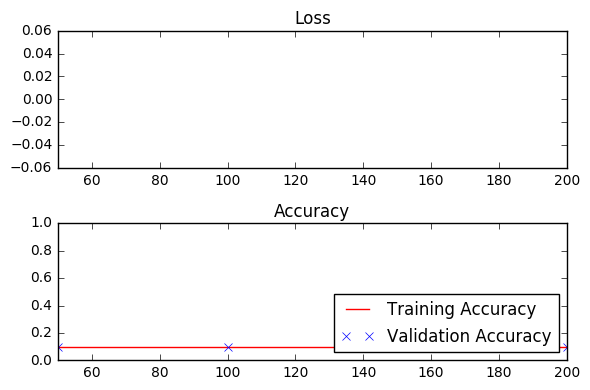

Validation accuracy at 0.10038094967603683
Finish running the configuration Basic Conf #0
['Basic Conf #1', 1, 50, 0.01]
Start running the configuration Basic Conf #1





Epoch  1/1:   0%|          | 0/3990 [00:00<?, ?batches/s]

Epoch  1/1:   0%|          | 1/3990 [00:00<38:16,  1.74batches/s]

Epoch  1/1:   1%|▏         | 51/3990 [00:01<26:41,  2.46batches/s]

Epoch  1/1:   3%|▎         | 101/3990 [00:01<18:40,  3.47batches/s]

Epoch  1/1:   4%|▍         | 151/3990 [00:02<13:07,  4.87batches/s]

Epoch  1/1:   5%|▌         | 201/3990 [00:02<09:18,  6.79batches/s]

Epoch  1/1:   6%|▋         | 251/3990 [00:03<06:39,  9.36batches/s]

Epoch  1/1:   8%|▊         | 301/3990 [00:04<04:49, 12.74batches/s]

Epoch  1/1:   9%|▉         | 351/3990 [00:04<03:33, 17.06batches/s]

Epoch  1/1:  10%|█         | 401/3990 [00:05<02:40, 22.36batches/s]

Epoch  1/1:  11%|█▏        | 451/3990 [00:06<02:03, 28.62batches/s]

Epoch  1/1:  13%|█▎        | 501/3990 [00:06<01:38, 35.55batches/s]

Epoch  1/1:  14%|█▍        | 551/3990 [00:07<01:20, 42.82batches/s]

Epoch  1/1:  15%|█▌        | 601/3990 [00:07<01:07, 49.94batches/s]

Epoch  1/1:  16%|█▋        | 651/3990 [00:08

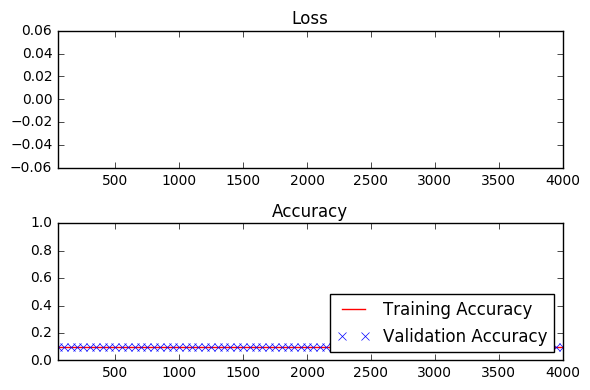

Validation accuracy at 0.10038094967603683
Finish running the configuration Basic Conf #1
['Basic Conf #2', 1, 300, 0.01]
Start running the configuration Basic Conf #2




Epoch  1/1:   0%|          | 0/665 [00:00<?, ?batches/s]

Epoch  1/1:   0%|          | 1/665 [00:00<06:32,  1.69batches/s]

Epoch  1/1:   4%|▍         | 29/665 [00:00<04:23,  2.41batches/s]

Epoch  1/1:   8%|▊         | 51/665 [00:01<03:03,  3.34batches/s]

Epoch  1/1:  12%|█▏        | 79/665 [00:01<02:03,  4.75batches/s]

Epoch  1/1:  15%|█▌        | 101/665 [00:02<01:28,  6.41batches/s]

Epoch  1/1:  20%|█▉        | 130/665 [00:02<00:59,  9.06batches/s]

Epoch  1/1:  23%|██▎       | 151/665 [00:02<00:44, 11.60batches/s]

Epoch  1/1:  27%|██▋       | 181/665 [00:02<00:29, 16.30batches/s]

Epoch  1/1:  30%|███       | 201/665 [00:03<00:24, 19.15batches/s]

Epoch  1/1:  35%|███▍      | 230/665 [00:03<00:16, 26.59batches/s]

Epoch  1/1:  38%|███▊      | 251/665 [00:04<00:14, 28.44batches/s]

Epoch  1/1:  42%|████▏     | 280/665 [00:04<00:09, 38.97batches/s]

Epoch  1/1:  45%|████▌     | 301/665 [00:05<00:09, 36.72batches/s]

Epoch  1/1:  49%|████▉     | 328/665 [00:05<00:06, 49.56batch

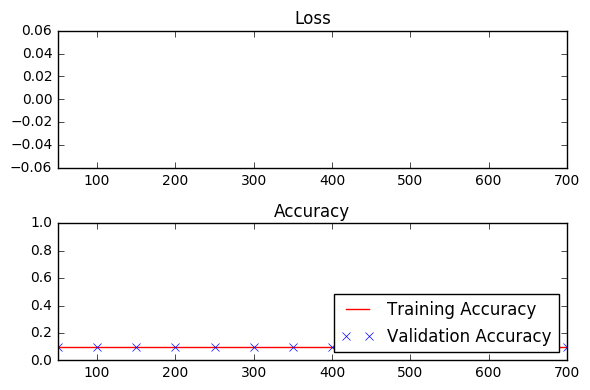

Validation accuracy at 0.10038094967603683
Finish running the configuration Basic Conf #2
['Basic Conf #3', 1, 500, 0.01]
Start running the configuration Basic Conf #3




Epoch  1/1:   0%|          | 0/399 [00:00<?, ?batches/s]

Epoch  1/1:   0%|          | 1/399 [00:00<03:50,  1.73batches/s]

Epoch  1/1:   5%|▌         | 20/399 [00:00<02:34,  2.46batches/s]

Epoch  1/1:   9%|▉         | 37/399 [00:00<01:43,  3.49batches/s]

Epoch  1/1:  13%|█▎        | 51/399 [00:01<01:14,  4.67batches/s]

Epoch  1/1:  17%|█▋        | 69/399 [00:01<00:50,  6.60batches/s]

Epoch  1/1:  22%|██▏       | 87/399 [00:01<00:33,  9.27batches/s]

Epoch  1/1:  25%|██▌       | 101/399 [00:02<00:26, 11.24batches/s]

Epoch  1/1:  30%|██▉       | 119/399 [00:02<00:17, 15.63batches/s]

Epoch  1/1:  34%|███▍      | 137/399 [00:02<00:12, 21.48batches/s]

Epoch  1/1:  38%|███▊      | 151/399 [00:03<00:11, 21.65batches/s]

Epoch  1/1:  42%|████▏     | 169/399 [00:03<00:07, 29.39batches/s]

Epoch  1/1:  47%|████▋     | 187/399 [00:03<00:05, 39.07batches/s]

Epoch  1/1:  50%|█████     | 201/399 [00:03<00:06, 31.82batches/s]

Epoch  1/1:  55%|█████▍    | 219/399 [00:04<00:04, 42.18batches

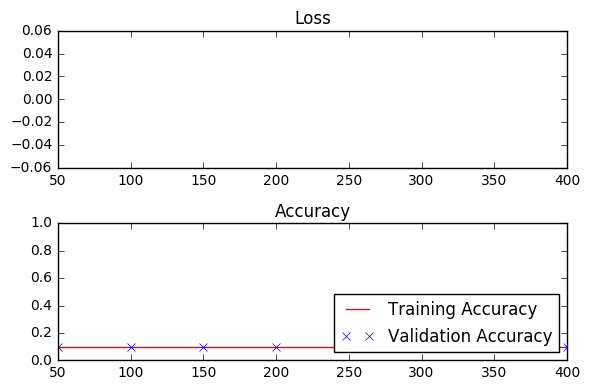

Validation accuracy at 0.10038094967603683
Finish running the configuration Basic Conf #3
['Basic Conf #4', 1, 2000, 0.01]
Start running the configuration Basic Conf #4




Epoch  1/1:   0%|          | 0/100 [00:00<?, ?batches/s]

Epoch  1/1:   1%|          | 1/100 [00:00<00:58,  1.69batches/s]

Epoch  1/1:   6%|▌         | 6/100 [00:00<00:39,  2.38batches/s]

Epoch  1/1:  11%|█         | 11/100 [00:00<00:26,  3.33batches/s]

Epoch  1/1:  16%|█▌        | 16/100 [00:00<00:18,  4.62batches/s]

Epoch  1/1:  21%|██        | 21/100 [00:01<00:12,  6.33batches/s]

Epoch  1/1:  26%|██▌       | 26/100 [00:01<00:08,  8.54batches/s]

Epoch  1/1:  31%|███       | 31/100 [00:01<00:06, 11.24batches/s]

Epoch  1/1:  36%|███▌      | 36/100 [00:01<00:04, 14.55batches/s]

Epoch  1/1:  41%|████      | 41/100 [00:01<00:03, 18.32batches/s]

Epoch  1/1:  46%|████▌     | 46/100 [00:01<00:02, 22.37batches/s]

Epoch  1/1:  51%|█████     | 51/100 [00:02<00:03, 14.46batches/s]

Epoch  1/1:  56%|█████▌    | 56/100 [00:02<00:02, 18.29batches/s]

Epoch  1/1:  61%|██████    | 61/100 [00:02<00:01, 22.44batches/s]

Epoch  1/1:  66%|██████▌   | 66/100 [00:02<00:01, 26.65batches/s]

Epoc

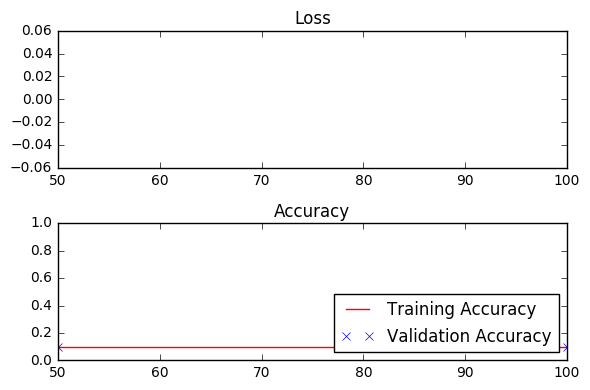

Validation accuracy at 0.10038094967603683
Finish running the configuration Basic Conf #4


In [36]:
sources=[train_url,test_url]
repositories = [train_repository,test_repository]

dp = DataProvider(sources, repositories, train_hash_key, test_hash_key, pickle_file)
if dp is not None:
    dp.serialize()
train_features,train_labels,\
                       valid_features, valid_labels,test_features,test_labels = dp.deserialize()
ds = Dataset(train_features,train_labels,\
                       valid_features, valid_labels,test_features,test_labels)

dnn = DeepNeuralNetworks(ds)
#Scenario configuration #1
epochs = 1
batch_size = {2000,1000,500,300,50}
learning_rate = .01
conf = Configuration('Basic Conf',epochs, batch_size, learning_rate)
dnn.run_configuration(conf)

